In [165]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gd
import seaborn as sns
%matplotlib inline

np.random.seed(7)
df=pd.read_csv("data.csv")

fr0 = df[df["Class"] == 0].sample( n=492 ).copy()
fr1 = df[df["Class"] == 1].copy()

drop_arr = [ "Time", "V13", "V15", "V24", "V25" ]
#drop_arr = [ "Time" ]

df=pd.concat([fr0, fr1]).drop(drop_arr, 1)

# prepare data for amount prediction

ami = df[df["Class"] == 1].drop(["Amount", "Class"], 1).values
amo = df[df["Class"] == 1]["Amount"].values

amo2 = np.log(amo+1)

Parameter tuning

In [166]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error

import xgboost

kf = KFold( n_splits = 4, shuffle = True )

estim_col, depth_col, child_col, learninig_rate_col, gamma_col, abs_err1, squ_err1, abs_err2, squ_err2 = [],[],[],[],[],[],[],[],[]

for estim in [ 50, 100, 200, 400 ]:
    for depth in [ 3, 5, 7, 8, 9 ]:
        for child in [ 1, 3, 5, 7 ]:
            for learning_rate in [ 0.01, 0.1, 0.5 ]:
                for gamma in [ 0, 0.01, 0.1, 1, 10 ]:

                    abs_res1, abs_res2, squ_res1, squ_res2 = [], [], [], []

                    for train_index, test_index in kf.split( ami ):
                    
                        xtrain,  xtest = ami[train_index], ami[test_index]
                        ytrain1, ytest = amo[train_index], amo[test_index]
                        ytrain2        = amo2[train_index]
            
                        # first method
                        xgreg1 = xgboost.XGBRegressor( n_estimators = estim, max_depth = depth, min_child_weight = child, 
                                                  learning_rate = learning_rate, gamma = gamma )
                        xgreg1.fit( xtrain, ytrain1 )      
                        ypred1 = xgreg1.predict( xtest )
            
                        abs_res1.append( mean_absolute_error( ypred1, ytest ) )
                        squ_res1.append( mean_squared_error(  ypred1, ytest ) )
            
                        # second method
            
                        xgreg2 = xgboost.XGBRegressor( n_estimators = estim, max_depth = depth, min_child_weight = child, 
                                                  learning_rate = learning_rate, gamma = gamma )
                        xgreg2.fit( xtrain, ytrain2 )
                        ypred2 = xgreg2.predict( xtest )
            
                        ypred2 = np.exp( ypred2 ) - 1
            
                        abs_res2.append( mean_absolute_error( ypred2, ytest ) )
                        squ_res2.append( mean_squared_error(  ypred2, ytest ) )
            
                    estim_col.append(estim)
                    depth_col.append(depth)
                    child_col.append(child)
                    learninig_rate_col.append(learning_rate)
                    gamma_col.append(gamma)
                
                    abs_err1.append( np.mean( abs_res1 ) )
                    abs_err2.append( np.mean( abs_res2 ) )
                    squ_err1.append( np.mean( squ_res1 ) )
                    squ_err2.append( np.mean( squ_res2 ) )

In [167]:
fit_res = pd.DataFrame( 
    np.array( [ estim_col, depth_col, child_col, learninig_rate_col, gamma_col, abs_err1, squ_err1, abs_err2, squ_err2 ]).transpose(),
    columns = [ "estim", "depth", "child", "lrate", "gamma", "abs1", "squ1", "abs2", "squ2" ] )

fit_res = fit_res.round(1)

Is it worth to use second method?

In [170]:
print( "%.2f" % ( (fit_res["abs1"] > fit_res["abs2"]).sum() /  fit_res.size ) )

0.05


Find "best" parameters for regressor:

In [171]:
fit_res.sort_values("abs1").head(n=8)

,estim,depth,child,lrate,gamma,abs1,squ1,abs2,squ2
982,400.0,5.0,3.0,0.1,0.1,63.6,17183.3,71.7,30916.6
665,200.0,5.0,1.0,0.1,0.0,63.7,17546.8,67.7,30489.7
683,200.0,5.0,3.0,0.1,1.0,64.4,20099.9,69.1,29200.2
1160,400.0,9.0,3.0,0.1,0.0,64.5,18884.5,64.3,25533.4
907,400.0,3.0,1.0,0.1,0.1,64.7,17819.0,81.7,75751.7
607,200.0,3.0,1.0,0.1,0.1,64.9,16916.8,76.8,40856.0
759,200.0,7.0,5.0,0.1,10.0,65.0,18264.8,84.4,44398.5
624,200.0,3.0,3.0,0.1,10.0,65.1,17820.7,86.3,40132.0


Out of curiosity, we can check what features are most important

/home/pawel/anaconda3/envs/fraud_detection/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


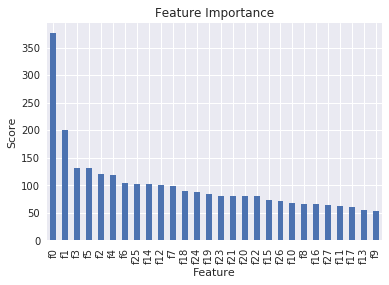

In [142]:
feat_imp = pd.Series(xgreg.booster().get_fscore()).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importance')
plt.xlabel('Feature')
plt.ylabel('Score')